In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import math
import xgboost
from sklearn.model_selection import KFold
import sklearn.metrics as metrics

import keras
from keras import Sequential
from keras.layers import Flatten, Embedding, Dense

Importing the all the modules required for the program

#Loading data

load data as a csv file

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ANDYp-5102/andy-s/master/data.csv")

visualizing first 6 lines

In [ ]:
df.head(15)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,0,2000-01,52,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,0,2000-01,5,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8
8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,0,2000-01,12,12,1.0,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9
9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,0,2000-01,36,12,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10


Checking the type for data

In [ ]:
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

Checking the contents of each feature


In [ ]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

###Quantitative data

The use of this function: Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [ ]:
df.describe(include=['int64'])

,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,7.110499,91.107535,4.885624,2.519432,0.146562,28.365085,13.437437,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,110.124578,87.791361,3.449897,1.153665,0.353674,17.478949,9.374189,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,5.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,15.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,21.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,79.000000,1.610613e+09,30697.000000


Each conlumn of the table represent a specific factor and refers to different types of data.For example, loc_x and loc_y refers to the location of the shot taken considering the basketball court as a X-Y diagram.



###Descriptive data

In [ ]:
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


#Data Visualization


Shot made=1 Shot missed=0

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


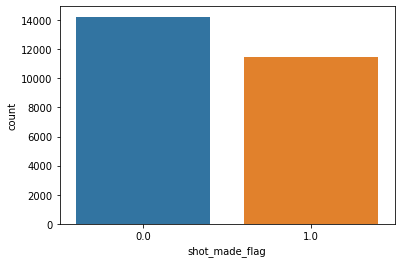

In [ ]:
sns.countplot(df.shot_made_flag)

The left is missed shots and the right is made shots. You can see that Kobe is not that efficient due to the mass number of shot attempts.

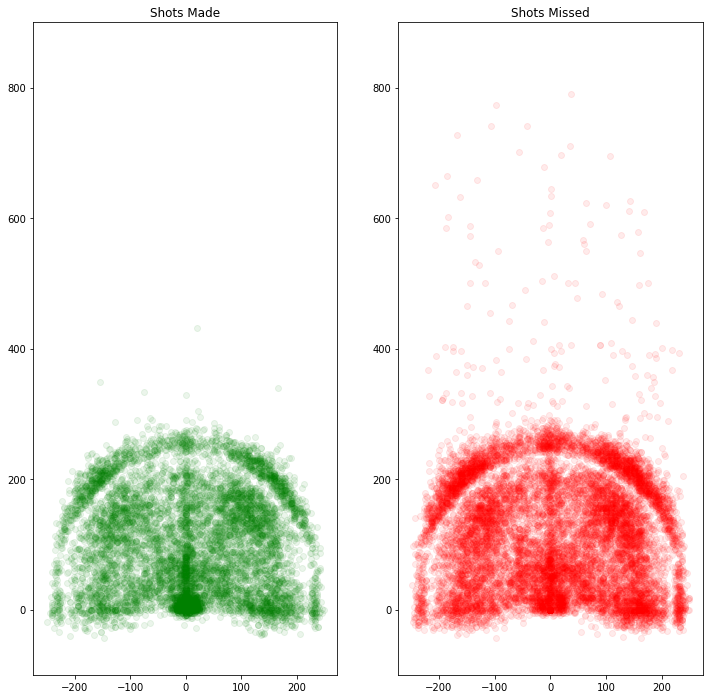

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.scatter(df.loc[df.shot_made_flag==1, 'loc_x'], df.loc[df.shot_made_flag==1, 'loc_y'], alpha=0.08, c='g')
plt.title('Shots Made')
plt.ylim(-100, 900)
plt.subplot(122)
plt.scatter(df.loc[df.shot_made_flag==0, 'loc_x'], df.loc[df.shot_made_flag==0, 'loc_y'], alpha=0.08, c='r')
plt.title('Shots Missed')
plt.ylim(-100, 900)
plt.show()

Using scatter diagram would better demonstrate the data of made and missed shots

Obviously the distance matters, there are a lot of misses from far away the basket. In correspondence with intuition, the shots which he makes from near the basket have a higher success rate. Also number of misses are more from outer ring area. But there's a weird thing both have a lot of shots and miss from 0,0.

Counting the the number of shots made/missed

In [ ]:
c= df.loc[(df.loc_x==0) & (df.loc_y==0)]

c.shot_made_flag.value_counts()

1.0    2696
0.0    1625
Name: shot_made_flag, dtype: int64

##Minutes Remaining


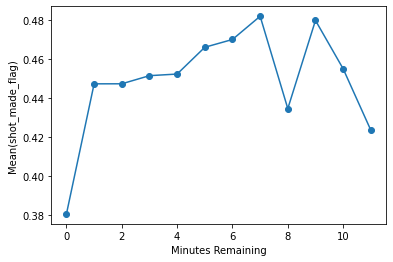

In [ ]:
c = df.groupby('minutes_remaining')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Minutes Remaining')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()

For those data with variables as continuous functions, for example minutes-shot_made; The use of broken line chart may be used rather than scatter diagrams to better indentify the trend.

Not much of a pattern here. Except for the 0th min. There's a sudden drop of mean of shot's made in the last minute.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


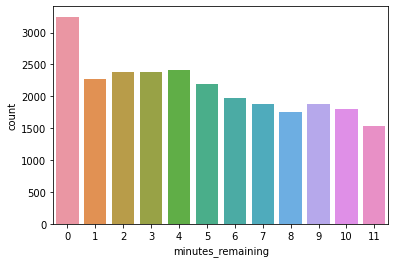

In [ ]:
sns.countplot(df.minutes_remaining)

There is a lot of attempts are made in the last second.

##Shot Distance

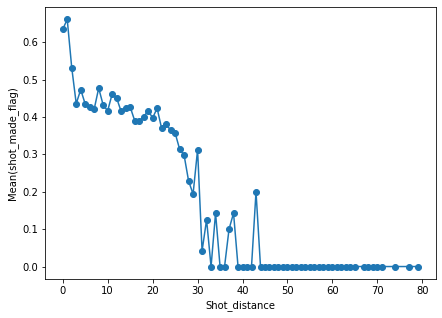

In [ ]:
c = df.groupby('shot_distance')['shot_made_flag'].mean()
plt.figure(figsize=(7, 5))
plt.plot(c.index, c.values)
plt.xlabel('Shot_distance')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()

As the distance increases the accuracy decreases.

##Categorical variables

In [ ]:
def color_generator(num_colors):
    colors = []
    for i in range(num_colors):
        colors.append((np.random.rand(), np.random.rand(), np.random.rand()))
    return colors

In [ ]:
colors = color_generator(100)

In [ ]:
def plot_zone_wise(zone_name):
    c_mean = df.groupby(zone_name)['shot_made_flag'].mean()
    plt.figure(figsize=(15,15))
    for i, area in enumerate(df[zone_name].unique()):
        plt.subplot(121)
        c = df.loc[(df[zone_name]==area)]
        plt.scatter(c.loc_x, c.loc_y,alpha=0.5 ,c=colors[i])
        plt.text(c.loc_x.mean(), c.loc_y.quantile(0.80), 
                 '%0.3f'%(c_mean[area]),size=15, 
                 bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
    plt.legend(df[zone_name].unique())
    plt.title(zone_name)
    plt.show()

This function is used to draw diagrams, by using pandas we could show more different sectors and using colors to distinguish them.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same 

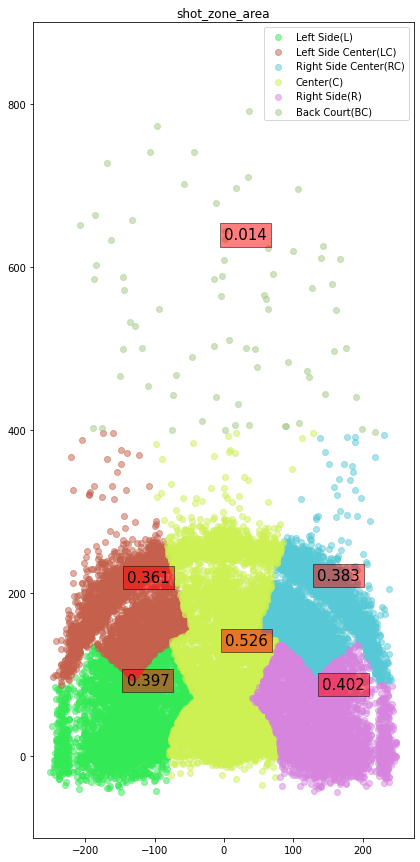

In [ ]:
plot_zone_wise('shot_zone_area')

This is a diagram demonstrating Kobe's shooting accuracy in different areas on the court. We could obtain a conclusion of Kobe's best spot of scoring on the court.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same 

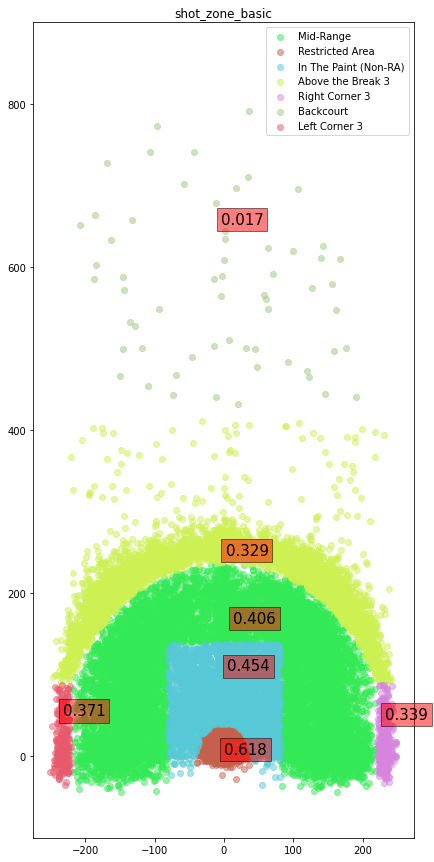

In [ ]:
plot_zone_wise('shot_zone_basic')

This one has the same function. But the regions of the court where shots are identifies have changed.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same 

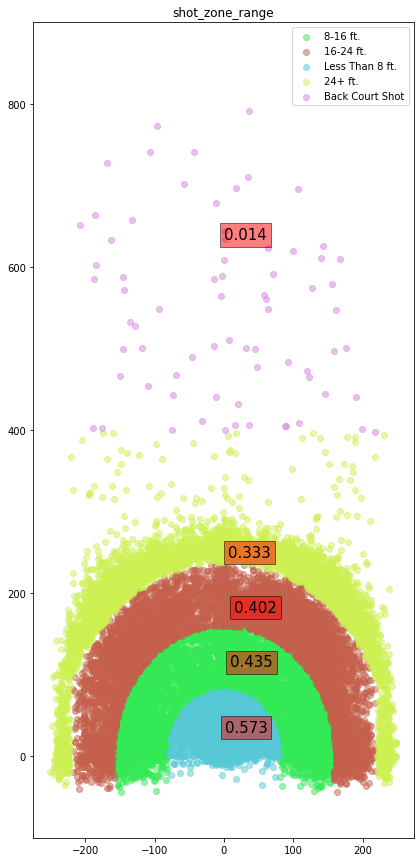

In [ ]:
plot_zone_wise('shot_zone_range')

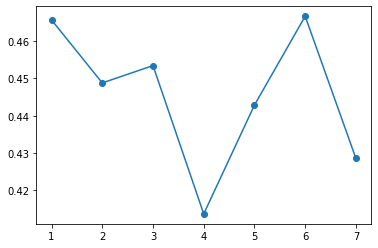

In [ ]:
c = df.groupby('period')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.scatter(c.index, c.values)
plt.show()

## Playoffs

Playoffs=1 Not playoffs=0

To explore whether playoffs would affect Kobe's shot accuracy.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


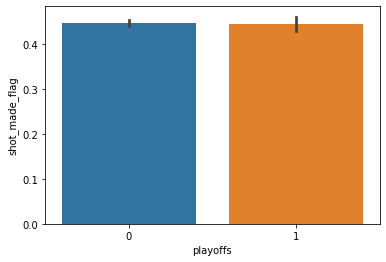

In [ ]:
sns.barplot('playoffs', 'shot_made_flag', data=df)

Clearly, there are less shots made in playoffs as there are less playoff games played.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


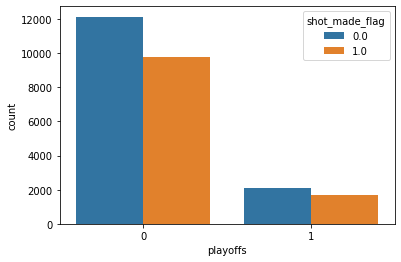

In [ ]:
sns.countplot('playoffs', hue ='shot_made_flag', data=df)


Kobe's shooting accuracy in slightly higher in playoffs. This might because that he played less playoff games or his better performance in the playoffs leading the Los Angeles Lakers.

His performance of each season

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


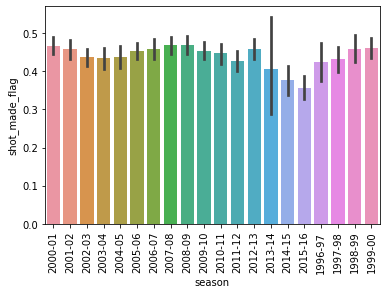

In [ ]:
sns.barplot('season', 'shot_made_flag', data=df)
plt.xticks(rotation='vertical')
plt.show()

Adding standard deviation np.std（）would increase the reliablility of each groups of data.

causition: Kobe tore his Achilles tendon in the 12-13 season.

##Shot_type

In this section we would investigate Kobe's scoring ability of different types of shots

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


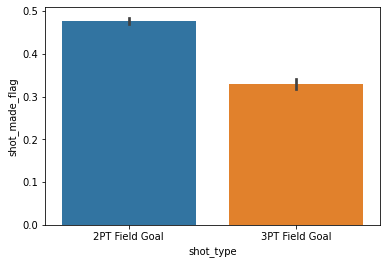

In [ ]:
sns.barplot(df.shot_type, df.shot_made_flag)

Overall, Kobe is better at scoring 2PT. This data fits in his playing style in reality.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


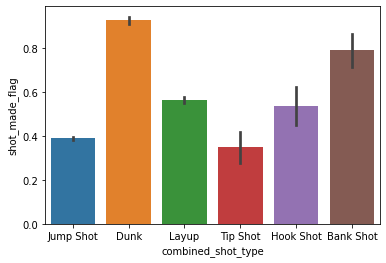

In [ ]:
sns.barplot(df.combined_shot_type, df.shot_made_flag)


We have listed six types of shot Kobe has made and plot a diagram with the accuracy and shot types

Dunk>Bankshot>Layup=Hook Shot>Tip Shot=Jump Shot

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


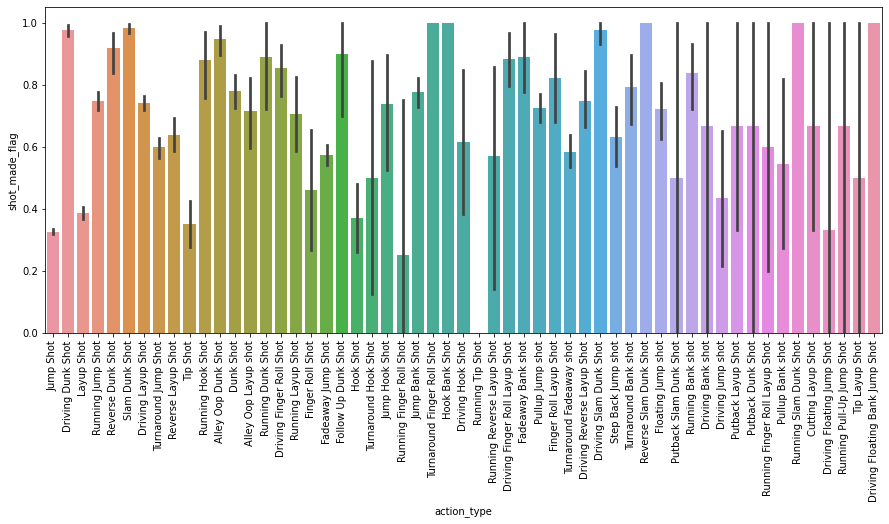

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot('action_type', 'shot_made_flag', data=df)
plt.xticks(rotation='vertical')
plt.show()

#Data Transformation + Feature Engineering

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ANDYp-5102/andy-s/master/data.csv")

Calculate the angle using x, y coordinates. y = 0 is at 90 degree.

In [ ]:
df['angle'] = df.apply(lambda row: 90 if row['loc_y']==0 else math.degrees(math.atan(row['loc_x']/abs(row['loc_y']))),axis=1)

Putting angles into different bins.

In [ ]:
df['angle_bin'] = pd.cut(df.angle, 7, labels=range(7))
df['angle_bin'] = df.angle_bin.astype(int)
df

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,angle,angle_bin
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,66.677303,6
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,90.000000,6
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,-36.801931,2
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,38.258303,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,90.000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693,1.193489,3
30693,Tip Shot,Tip Shot,398,49900088,34.0443,0,0,-118.2698,6,4,1,1999-00,5,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30694,90.000000,6
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,1,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695,-38.911472,1
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,1,1999-00,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696,6.622667,3


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same 

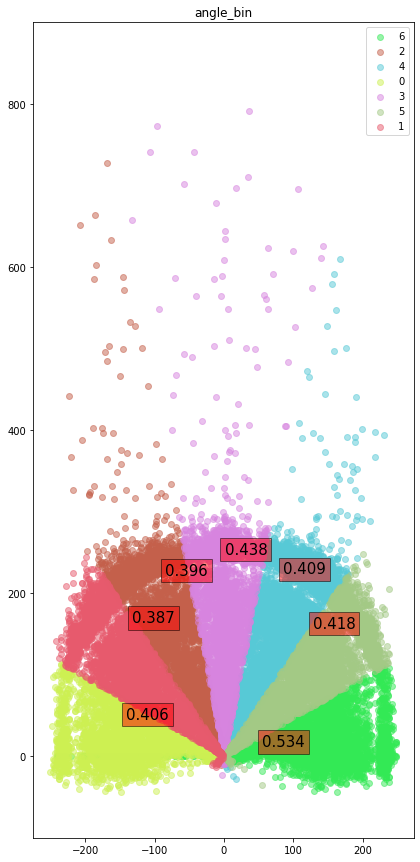

In [ ]:
plot_zone_wise('angle_bin')

6

In this chart, we are dividing the basketball court into six equal regions with same angles and record Kobe's accuracy in each.

We can also see that Kobe had attempted some long range shots throughout his career and his best scoring region is the right baseline section where he was shooting with 53.4% shooting percentage

do something similar to distance

In [ ]:
df['distance_bin'] = pd.cut(df.shot_distance, bins=10, labels=range(10))

Data cleaning: delete '-' in action_type, change Follow Up to followup, and do the same for finger roll. 

In [ ]:
df['action_type'] = df.action_type.apply(lambda x: x.replace('-', ''))
df['action_type'] = df.action_type.apply(lambda x: x.replace('Follow Up', 'followup'))
df['action_type'] = df.action_type.apply(lambda x: x.replace('Finger Roll','fingerroll'))

using countvectorizer to generate feature matrix

In [ ]:
cv = CountVectorizer(max_features=50, stop_words=['shot'])
shot_features = cv.fit_transform(df['action_type']).toarray()

shot_features = pd.DataFrame(shot_features, columns=cv.get_feature_names())
shot_features.head()

,alley,back,bank,cutting,driving,dunk,fadeaway,fingerroll,floating,followup,hook,jump,layup,oop,pullup,putback,reverse,running,slam,step,tip,turnaround
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Merge with dataframe

In [ ]:
df = pd.concat([df,shot_features], axis=1)

formating game date

In [ ]:
df['game_date'] = pd.to_datetime(df.game_date)
df['game_date_month'] = df.game_date.dt.month
df['game_date_quarter'] = df.game_date.dt.quarter

Calculating total time remaining

In [ ]:
df['time_remaining'] = df.apply(lambda row: row['minutes_remaining']*60+row['seconds_remaining'], axis=1)

We can see through visualization that his shot attempts in the last three seconds of the game dramatically decrease. This might be a result of long range shots(halfcourt shots or further) due to short of time.

In [ ]:
df['timeUnder4'] = df.time_remaining.apply(lambda x: 1 if x<4 else 0)

The relationship between accuracy and distance and angle

In [ ]:
ang_dist = df.groupby(['angle_bin', 'distance_bin'])['shot_made_flag'].agg([np.mean],as_index= False).reset_index()
ang_dist['group'] = range(len(ang_dist))
ang_dist.drop('mean', inplace=True, axis=1)
ang_dist.head()

,angle_bin,distance_bin,group
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,0,4,4


Joining columns {‘left’, ‘right’, ‘outer’, ‘inner’} on label or list of label

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same 

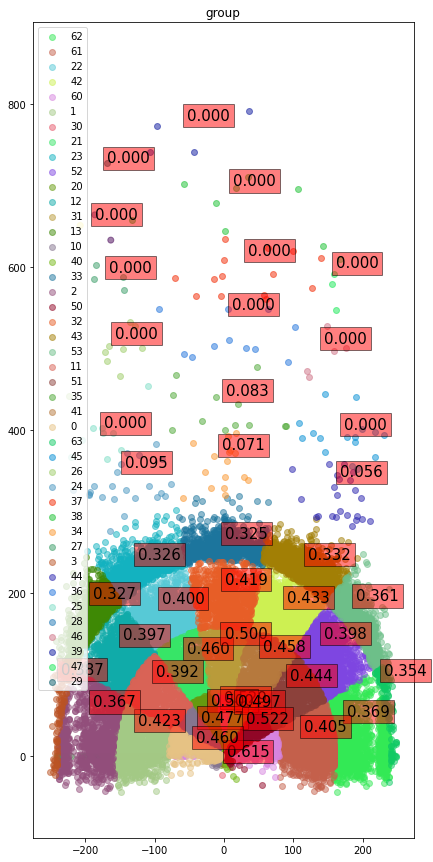

In [ ]:
df = df.merge(ang_dist, 'left', ['angle_bin', 'distance_bin'])
plot_zone_wise('group')

By dividing the whole court into more seperate parts, we could obtain a more precise data of Kobe Bryant's shooting percentage on the whole court. Obviously, the accuracy decreases as distance from the rim to the shooting position increases.

Drop unralated columns

In [ ]:
predictors = df.columns.drop(['game_event_id' #unique
                              , 'shot_made_flag'
                              , 'game_id' #unique
                              , 'shot_id' # id feature
                              , 'game_date'#other faetures from date used
                              , 'minutes_remaining'#transformed
                              , 'seconds_remaining'#transformed
                              ,'lat', 'lon' #same as loc_x, loc_y
                              , 'playoffs'#not important - from visualization
                              , 'team_id', 'team_name'#always same
                              , 'matchup' #transformed
                             ])

Label encoding(non numerical data --> numerical labels)


all 0,1 --> one hot coding

In [ ]:
le = LabelEncoder()
for col in predictors:
    if df[col].dtype=='object':
        df[col] = le.fit_transform(df[col])
df[predictors] #predictor: selected features

,action_type,combined_shot_type,loc_x,loc_y,period,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,angle,angle_bin,distance_bin,alley,back,bank,cutting,driving,dunk,fadeaway,fingerroll,floating,followup,hook,jump,layup,oop,pullup,putback,reverse,running,slam,step,tip,turnaround,game_date_month,game_date_quarter,time_remaining,timeUnder4,group
0,23,3,167,72,1,4,18,0,5,4,0,25,66.677303,6,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,627,0,62
1,23,3,-157,0,1,4,15,0,3,4,2,25,90.000000,6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,622,0,61
2,23,3,-101,135,1,4,16,0,2,4,0,25,-36.801931,2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,465,0,22
3,23,3,138,175,1,4,22,0,4,4,0,25,38.258303,4,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,412,0,42
4,5,1,0,0,2,4,0,0,1,5,4,25,90.000000,6,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,379,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,23,3,1,48,4,3,4,0,1,2,4,11,1.193489,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,2,365,0,30
30693,47,5,0,0,4,3,0,0,1,5,4,11,90.000000,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,2,365,0,60
30694,36,3,-134,166,4,3,21,0,2,4,0,11,-38.911472,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,2,208,0,12
30695,23,3,31,267,4,3,26,1,1,0,1,11,6.622667,3,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,2,130,0,33


#Sperating training and test data


train test split

In [ ]:
# test data is the data that has nulls in "shot_made_flag" colomn
test = df.loc[df.shot_made_flag.isnull(), predictors] # when shot_made_flag is null
test

,action_type,combined_shot_type,loc_x,loc_y,period,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,angle,angle_bin,distance_bin,alley,back,bank,cutting,driving,dunk,fadeaway,fingerroll,floating,followup,hook,jump,layup,oop,pullup,putback,reverse,running,slam,step,tip,turnaround,game_date_month,game_date_quarter,time_remaining,timeUnder4,group
0,23,3,167,72,1,4,18,0,5,4,0,25,66.677303,6,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,627,0,62
7,23,3,1,28,3,4,2,0,1,5,4,25,2.045408,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,4,485,0,30
16,10,4,0,0,1,4,0,0,1,5,4,30,90.000000,6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11,4,1,1,60
19,10,4,0,0,3,4,0,0,1,5,4,30,90.000000,6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11,4,646,0,60
32,23,3,163,76,1,4,17,0,5,4,0,31,65.002353,6,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11,4,686,0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,23,3,-23,222,4,3,22,0,1,4,0,11,-5.914946,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,2,447,0,32
30680,47,5,0,0,2,3,0,0,1,5,4,11,90.000000,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,2,40,0,60
30682,36,3,-68,48,3,3,8,0,3,2,2,11,-54.782407,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,2,690,0,11
30686,36,3,16,93,3,3,9,0,1,2,2,11,9.761775,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,2,337,0,31


get rid of the test data and set training label(ytr) to shot made flag, and training data to our predictors

In [ ]:
df.dropna(inplace=True) # when shot_made_flag is not null
ytr = df['shot_made_flag']
Xtr = df[predictors] #predictor: selected features

#Make prediction using Random Forest
reference:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Using random forest classifier to make prediction:

Random forest is composed of many decision trees, and there is no correlation between different decision trees.

When we carry out the classification task, each decision tree in the forest complete classification separately, and each decision tree will get its own classification result. The random forest will choose the result with the most vote(meaning, the result that most of the decision trees agree with) be the final classification result. 

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=70, max_depth=7)

clf.fit(Xtr, ytr) # train the model with Xtr and Ytr

predictions = clf.predict_proba(test)

n_jobs: number of jobs to run in parallel;
n_estimators: number of trees in the forest;
max_depth: max depth of the tree

printing the predicted results

In [ ]:
predictions

array([[0.64127327, 0.35872673],
       [0.61547162, 0.38452838],
       [0.32762982, 0.67237018],
       ...,
       [0.36304955, 0.63695045],
       [0.34260645, 0.65739355],
       [0.55388616, 0.44611384]])